In [153]:
import sys
import warnings
#from torchtext import data

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

from keras.models import load_model
from keras import backend as K
import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import itertools
from collections import Counter
from os import listdir
from os.path import isfile, join
import  json
from sklearn.utils import class_weight


from  keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical

from keras import backend as K
import keras
'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

In [154]:
stoplist = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post):       
    s= re.sub(r"http\S+", " <url> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9][0-9]\b', " <number> ",  s)
    s=emoji_pattern.sub(r'', s)
    s= list(s.split())
    s=[lemmatizer.lemmatize(token) for token in s]
        
    return s

In [155]:
df_train=pd.read_csv("../Train_data_compeition.csv")
df_val=pd.read_csv("../Validation_data_competition.csv")
df_test=pd.read_csv("../testset-competition.csv")
df_train.head()

,Unnamed: 0,tweet_content,harassment,IndirectH,PhysicalH,SexualH
0,0,pics mexican school girl naked melanie safka f...,1,0,0,1
1,1,RT shereiqns Having curly hair is a gotdamn ch...,0,0,0,0
2,2,BreakingNews 7 Unexplained Prisoners Deaths M...,0,0,0,0
3,3,girl dirty quarterback latino pokemon young h...,1,0,0,1
4,4,miliondollameat sexting n ngirl daddy n nme l...,1,0,0,1


In [208]:
def return_hars(pred, objetos):   #[0,1,0...]
    bol=np.asarray(pred).astype('bool')
    print (bol[:5])
    return bol#objetos[bol]

def return_objs_fase2(dataframe, objs_hars, testing=False):
    mini_df=dataframe.values[objs_hars]
    if testing:
        textos=mini_df[:,0]
        return textos, None
    else: 
        textos=mini_df[:,1]
        indices= mini_df[:,0]
        labels=mini_df[:,2:]
        return textos, labels, indices

In [157]:
X_train= np.load('matrices/X_train_max.npy') #fase 1
X_train_f2= np.load('matrices/X_train_f2_max.npy')  #fase 2
X_train_rnn= np.load('matrices/X_train_rnn_max.npy')  #fase 2
X_val_ig= np.load('matrices/X_val_ig_max.npy')
X_val_rnn_ig= np.load('matrices/X_val_rnn_ig.npy')

y_train_bi= np.load('matrices/y_train_bi_max.npy')
y_train_bic= np.load('matrices/y_train_bic_max.npy')
y_train_mul= np.load('matrices/y_train_mul_max.npy')

y_val_bic= np.load('matrices/y_val_bic_max.npy')
y_val_bin= np.load('matrices/y_val_bin_max.npy')
y_val_mu= np.load('matrices/y_val_mu_max.npy')
y_val_mul= np.load('matrices/y_val_mul_max.npy')

X_val_ig_bin=np.load('matrices/X_val_ig_binario.npy')

In [158]:
print (Counter(y_train_bi))
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_bi), y_train_bi)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)


Counter({0: 3661, 1: 2713})
[0.87052718 1.17471434]


In [159]:
max_input_lenght=76
X_train.shape

(6374, 76)

In [160]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [161]:
from keras import backend as K

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [162]:
y_val_bin[:5]

array([0, 0, 1, 0, 1])

Accuracy sobre validacion: 0.900235294117647
F1-score None sobre validación: [0.93089961 0.82064298]
F1-score macro sobre validación: 0.8757712934345474
Precision None sobre validación: [0.90666667 0.88181818]
Recall None sobre validación: [0.9564635  0.76740506]


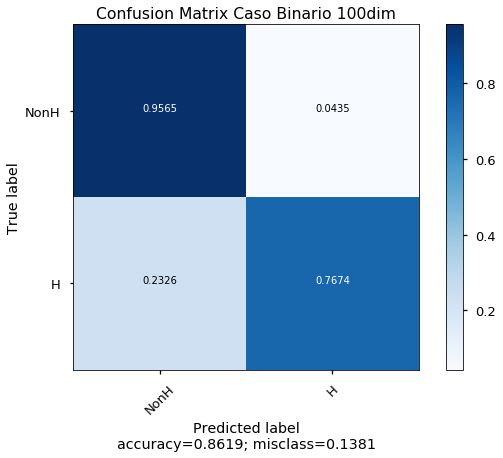

In [163]:
#### cargar modelo binario

modelo_binario = load_model('baselines/cnn1_binary_ce10_100.h5')

trainPredict = modelo_binario.predict(X_val_ig_bin, batch_size=64)
trainPredict=[np.round(pred) for pred in trainPredict]
acc_val= accuracy_score(y_val_bin, trainPredict)
f1_val=f1_score(y_val_bin, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_bin, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_bin, trainPredict, average=None) 
pre=precision_score(y_val_bin, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_bin, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH","H"],"Confusion Matrix Caso Binario 100dim")

In [276]:
0.8757*0.4067

0.35614719

In [165]:
predichos=np.asarray(trainPredict)[:,0]
predichos[:20]

array([0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 1.], dtype=float32)

In [209]:
objetos_binario=df_val['Unnamed: 0'].values
print (type(objetos_binario), predichos[:5])
ind_for_ph2=return_hars(predichos, objetos_binario )

<class 'numpy.ndarray'> [0. 0. 1. 0. 1.]
[False False  True False  True]


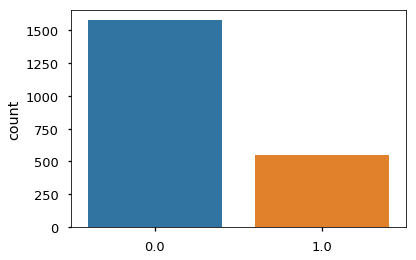

In [212]:
sns.countplot(predichos)

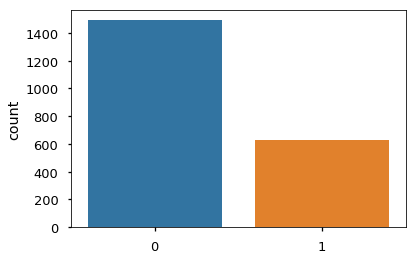

In [211]:
sns.countplot(y_val_bin)

In [213]:
new_objs, etiq, indx_pre= return_objs_fase2(df_val, ind_for_ph2)

In [216]:
ind_for_ph21=return_hars(y_val_bin, objetos_binario)
new_objs1, etiq1, indx_true= return_objs_fase2(df_val, ind_for_ph21)

[False False  True False  True]


In [217]:
indx_p2=list(set(indx_true).intersection(set(indx_pre)))

## Con los filtrados por fase 1

In [219]:
indx_true[:20]

array([6376, 6378, 6381, 6383, 6384, 6385, 6386, 6392, 6393, 6396, 6397,
       6399, 6401, 6403, 6405, 6406, 6407, 6413, 6418, 6419], dtype=object)

In [175]:
len(y_val_mu)

632

In [234]:
def new_matrices(indx_pre, indx_true, X_train, y_train):
    cont=0
    new_indx= []
    for value in indx_true:
        if value in indx_pre:
            new_indx.append(cont)
        cont+=1
    print (cont)
    new_y_train=y_train[[new_indx]]
    new_X_train=X_train[[new_indx]]#[[indx_p2]])

    return new_indx, new_X_train, new_y_train

def to_original(predichos, new_indx_p2, y_true):
    predichos=[tp+1 for tp in predichos]
    
    all_val=np.zeros(len(y_true),dtype='int32')
    all_true_val=np.zeros(len(y_true),dtype='int32')
    print (all_val.shape)
    y_true_adj=[tp+1 for tp in y_true]
    cont=0
    for i in new_indx_p2:
        all_val[i]=predichos[cont]
        all_true_val[i]=y_true_adj[cont]
        cont+=1
       
    return all_val, all_true_val

In [220]:
new_indx_p2, new_X_val_ig, new_y_val_mu= new_matrices(indx_pre, indx_true, X_val_ig, y_val_mu)

632


In [199]:
len(new_indx_p2)/len(indx1)

0.7674050632911392

In [222]:
modelo_multi = load_model('baselines/cnn1_100_multi_focal20_100.h5')

(632,)
Accuracy sobre validacion: 0.8591772151898734
F1-score None sobre validación: [0.08510638 0.04       0.90034364]
F1-score macro sobre validación: 0.3418166751968024
Precision None sobre validación: [0.08       0.03030303 0.92037471]
Recall None sobre validación: [0.09090909 0.05882353 0.88116592]


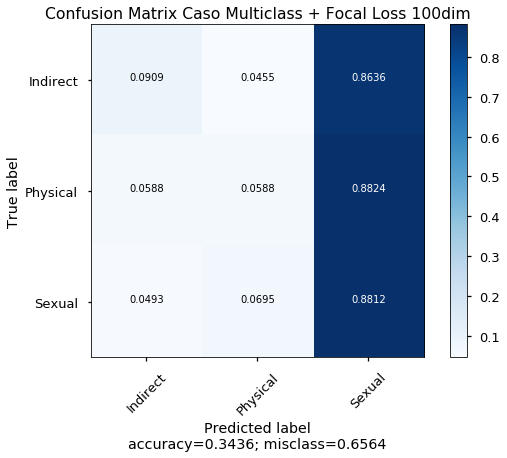

In [275]:
trainPredict = modelo_multi.predict(new_X_val_ig, batch_size=64).argmax(axis=-1)
new_pred, new_y_val= to_original(trainPredict, new_indx_p2, y_val_mu)
f1_val=f1_score(new_y_val, new_pred, average=None, labels=[1,2,3])  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(new_y_val, new_pred, average='macro',labels=[1,2,3])  # labels=np.unique(trainPredict)
acc_val= accuracy_score(new_y_val, new_pred)#,labels=[1,2,3])
rec=recall_score(new_y_val, new_pred, average=None,labels=[1,2,3]) 
pre=precision_score(new_y_val, new_pred, average=None,labels=[1,2,3]) 
matriz_val=confusion_matrix(new_y_val, new_pred,labels=[1,2,3])

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),['Indirect','Physical','Sexual'],"Confusion Matrix Caso Multiclass + Focal Loss 100dim")

Accuracy sobre validacion: 0.843298969072165
F1-score None sobre validación: [0.15789474 0.14545455 0.91676169]
F1-score macro sobre validación: 0.4067036566226388
Precision None sobre validación: [0.12       0.12121212 0.94145199]
Recall None sobre validación: [0.23076923 0.18181818 0.89333333]


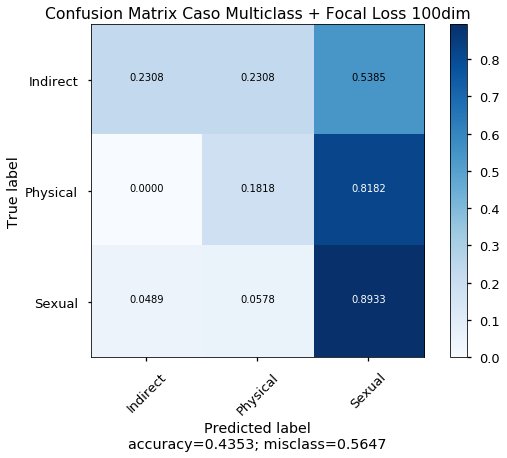

In [264]:
trainPredict = modelo_multi.predict(new_X_val_ig, batch_size=64).argmax(axis=-1)
f1_val=f1_score(new_y_val_mu, trainPredict, average=None)#, labels=[1,2,3])  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(new_y_val_mu, trainPredict, average='macro')#,labels=[1,2,3])  # labels=np.unique(trainPredict)
acc_val= accuracy_score(new_y_val_mu, trainPredict)
rec=recall_score(new_y_val_mu, trainPredict, average=None) 
pre=precision_score(new_y_val_mu, trainPredict, average=None) 
matriz_val=confusion_matrix(new_y_val_mu, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),['Indirect','Physical','Sexual'],"Confusion Matrix Caso Multiclass + Focal Loss 100dim")

In [270]:
print (len(trainPredict))
print (len(new_y_val_mu))
f1_score(new_y_val_mu, trainPredict, average=None)

485
485


array([0.15789474, 0.14545455, 0.91676169])

### Con todos los datos

Accuracy sobre validacion: 0.7753164556962026
F1-score None sobre validación: [0.38167939 0.19565217 0.87608069]
F1-score macro sobre validación: 0.4844707516228906
Precision None sobre validación: [0.41666667 0.16071429 0.88372093]
Recall None sobre validación: [0.35211268 0.25       0.86857143]


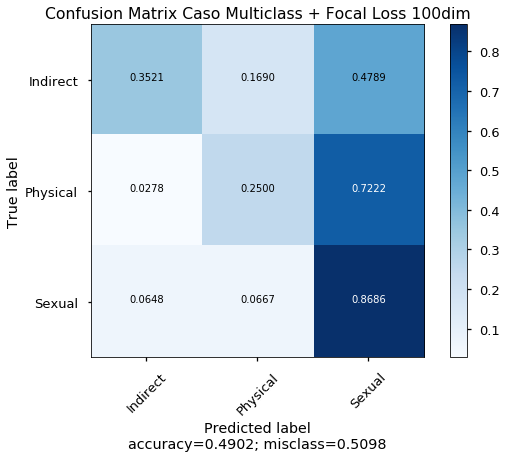

In [76]:
modelo_binario = load_model('baselines/cnn1_100_multi_focal20_100.h5')

trainPredict = modelo_binario.predict(X_val_ig, batch_size=64).argmax(axis=-1)
acc_val= accuracy_score(y_val_mu, trainPredict)
f1_val=f1_score(y_val_mu, trainPredict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_mu, trainPredict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_mu, trainPredict, average=None) 
pre=precision_score(y_val_mu, trainPredict, average=None) 
matriz_val=confusion_matrix(y_val_mu, trainPredict)

print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),['Indirect','Physical','Sexual'],"Confusion Matrix Caso Multiclass + Focal Loss 100dim")

In [66]:
X_val_ig.shape

(632, 32)